In [1]:
import os
import pprint
from igor2.packed import load as loadpxp

import matplotlib.pylab as plt
import numpy as np
import statistics
from scipy import stats

import pandas as pd
import csv

## Methods needed

In [26]:
def find_nm_files(root_folder):
    files_ = []
    
    # Walk through all directories and files in the root_folder
    for folder, _, files in os.walk(root_folder):
        # Check each file in the current directory
        for file in files:

            # Skip files with specific extensions
            if any(ext in file for ext in ['HDF5', 'txt', 'pdf', 'log', 'xlsx']):
                break
            # Construct the full path of the file
            file_path = os.path.join(folder, file)
            normalized_path = os.path.normpath(file_path)
            forward_slash_path = normalized_path.replace("\\", "/")
            files_.append(forward_slash_path)
            print('-', file)

    return files_

def get_datafiles(files):
    datafiles = []
    print(files)
    for file in files:
        print(file)
        datafiles.append(loadpxp(file))
    return datafiles

def get_recordings(datafile):
    try:
        DATA = []
        i = 0
        while True:
            key = b'RecordA%i' % i
            if key in datafile[1]['root']:
                DATA.append(datafile[1]['root'][key].wave['wave']['wData'])
                i += 1
            else:
                break
        recordings = np.array(DATA,dtype=np.float16) #uses half the memory
        return recordings
    except Exception as e:
        print(f'Recordings were not loaded: {e}')
        return -1

def get_batches(list, batch_size=6):
    #batch_size = 6
    means = []
    std = []
    for i in range(0, len(list), batch_size):
        means.append(np.mean(list[i:i+batch_size]))
        #sem.append(stats.sem(list[i:i+batch_size]))
        std.append(np.std(list[i:i+batch_size]))
    return means, std


def find_noise(recording):
    baseline = recording[52000:58000]
    mean_baseline = np.mean(baseline)
    std_baseline = np.std(baseline)
    min_baseline = np.min(baseline)
    noise = np.abs(mean_baseline - min_baseline)
    #noise = 2*std_baseline
    #print("noise : ", noise)
    return noise

def get_diffs3(self):
        diffs = []
        i=0
        for recording in self.recordings:
            diff = self.find_diff2(recording)
            noise = self.find_noise(recording)

            diffs.append(diff)
            '''
            if diff>=noise:
                diffs.append(diff)
            
            if diff<noise:
                diffs.append(0)
                #print("difference is actually noise")  
            '''  
            #print(i)
            i+=1
            #print("diff : ", diff)
'''
def get_diffs3(recordings):
    diffs = []
    i=0
    for recording in recordings:
        diff = find_diff2(recording)
        diffs.append(diff)
        #print(i)
        noise = find_noise(recording)
        
        if diff<noise:
            diffs.append(0)
            #print("difference is actually noise")  
        i+=1
        #print("diff : ", diff)
    
    return diffs
'''
def find_diff2(recording):

    #find baseline
    recording_baseline = recording[52000:58000]
    avg_baseline = statistics.mean(recording_baseline)

    #find minimum
    recording_roi = recording[60200:62000]
    min = np.min(recording_roi)

    #compute diff
    diff =  avg_baseline - min

    #print("baseline : ",avg_baseline)
    #print("min : ",min)
    #print("diff : ",diff)

    return diff

def get_baselines(recordings):
    baselines = []
    i=0
    for recording in recordings:
        baseline = recording[52000:58000]  #good values?
        baselines.append(baseline)
        if np.mean(baseline) <= -0.7:
            print("cell was lost at the sweep ", i, " ( = ", i/6, " min). The leak was ", np.mean(baseline) )
        i+=1
    return baselines



def find_diff(recording):

    #find baseline
    recording_baseline = recording[52000:58000]
    avg_baseline = statistics.mean(recording_baseline)

    #find minimum
    recording_roi = recording[60200:62000]
    min = np.min(recording_roi)

    #compute diff
    diff =  min - avg_baseline

    #print("baseline : ",avg_baseline)
    #print("min : ",min)
    #print("diff : ",diff)

    return diff

def get_diffs(recordings):
    diffs = []
    for recording in recordings:
        diff = find_diff(recording)
        if diff>-0.17 :
            diffs.append(diff)
    return diffs

def get_Ids(recordings):
    Ids = []
    for recording in recordings:
        baseline = recording[12000:19000]
        max = np.max(recording[19000:21000])
        Ids.append(max-baseline)
    return Ids

def find_noise(recording):
        baseline = recording[52000:58000]
        mean_baseline = np.mean(baseline)
        std_baseline = np.std(baseline)
        min_baseline = np.min(baseline)
        print("mean bsl", mean_baseline)
        print("min baseline ",min_baseline)
        #noise = np.abs(mean_baseline - min_baseline)
        noise = std_baseline
        #print("noise : ", noise)
        return noise
    
def get_noises(recordings):
        noises = []
        for recording in recordings:
            noise = find_noise(recording)
            noises.append(noise)
        return noises
    

## try with one file

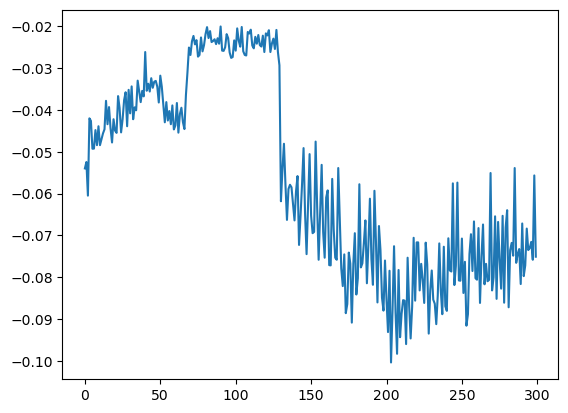

In [3]:
datafile = loadpxp('D:/Internship_Rebola_ICM/EXP-RECORDINGS/RAW-DATA-TO-ANALYSE-WASHOUT-q/nm11Jul2024c0/nm11Jul2024c0_000.pxp')
recordings = get_recordings(datafile)


mean bsl -0.0419
min baseline  -0.06107
mean bsl -0.04208
min baseline  -0.06235
mean bsl -0.03857
min baseline  -0.05786
mean bsl -0.04092
min baseline  -0.06107
mean bsl -0.041
min baseline  -0.0617
mean bsl -0.0414
min baseline  -0.05914
mean bsl -0.04596
min baseline  -0.0662
mean bsl -0.04654
min baseline  -0.0662
mean bsl -0.0461
min baseline  -0.06555
mean bsl -0.04294
min baseline  -0.06366
mean bsl -0.0461
min baseline  -0.06494
mean bsl -0.04437
min baseline  -0.063
mean bsl -0.04507
min baseline  -0.06366
mean bsl -0.04477
min baseline  -0.06366
mean bsl -0.04773
min baseline  -0.0662
mean bsl -0.04532
min baseline  -0.06366
mean bsl -0.04495
min baseline  -0.0669
mean bsl -0.0444
min baseline  -0.06555
mean bsl -0.04486
min baseline  -0.06555
mean bsl -0.0459
min baseline  -0.0675
mean bsl -0.0438
min baseline  -0.0643
mean bsl -0.04587
min baseline  -0.07007
mean bsl -0.04434
min baseline  -0.0669
mean bsl -0.04282
min baseline  -0.0643
mean bsl -0.04404
min baseline  -0.0

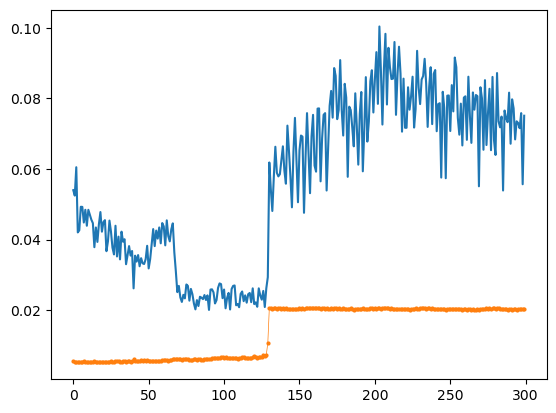

In [27]:
diffs = []
for recording in recordings:
    diffs.append(find_diff(recording))
plt.plot(np.abs(diffs))

noises = get_noises(recordings)
#noises_m, noises_std = get_batches(noises)
plt.plot(noises, marker="o", linewidth=0.5, markersize=2)

print("noises",noises)
print()

In [25]:
datafile = loadpxp('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp')
recordings = get_recordings(datafile)
diffs = get_diffs(recordings)

len(recordings)

get_batches_rec(diffs)

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp


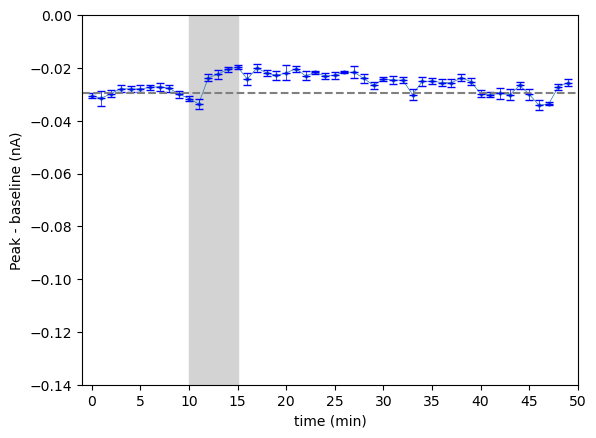

In [13]:
file = ('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp')
print(file)
datafile = loadpxp(file)
recordings = get_recordings(datafile)
diffs = get_diffs(recordings)
batches_m, batches_std = get_batches_rec(diffs)

fig, ax = plt.subplots()
        
ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

ax.set_xlim(-1,50)
ax.set_ylim(-0.14, 0)
ax.set_ylabel("Peak - baseline (nA)")
ax.set_xlabel("time (min)")
ax.axvspan(10, 15, color='lightgrey')
ax.set_xticks(np.arange(0, 51, 5))
plt.axhline(np.mean(batches_m[0:5]), color = "grey", linestyle = "--")
  
plt.show()


D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp
[0.024988670398124246, 0.025554444850972288]


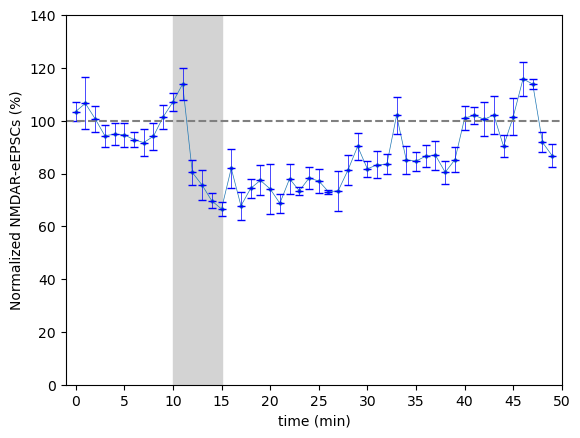

In [18]:
print(file)
datafile = loadpxp(file)
recordings = get_recordings(datafile)
#diffs = get_diffs2(recordings)
diffs = get_diffs3(recordings)
batches_m, batches_std = get_batches_rec(diffs)
print(batches_m[35:37])

# Calculate baseline mean and standard deviation
baseline_m = np.mean(batches_m[0:5])
baseline_std = np.std(batches_m[0:5])

# Normalization by baseline
batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

fig, ax = plt.subplots()
ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
ax.set_xlim(-1, 50 )
ax.set_ylim( 0, 140)
ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
ax.set_xlabel("time (min)")
ax.set_xticks(np.arange(0, 51, 5))
ax.axvspan(10, 15, color='lightgrey')
plt.axhline(100, color="grey", linestyle="--")

plt.show()

## try for all files

In [24]:
directory = 'D:\Internship_Rebola_ICM\EXP-recordings\RAW-DATA-TO-ANALYSE-WASHOUT'
files = find_nm_files(directory)
files

'''
if os.path.exists(directory):
    print(f"The directory {directory} exists.")
'''

- nm20Jun2024c0_002.pxp
- nm21Jun2024c0_000.pxp
- nm28Jun2024c1_000.pxp
- nm28Jun2024c0_000.pxp
- nm03Jul2024c2_000.pxp
- nm03Jul2024c0_000.pxp
- nm04Jul2024c1_000.pxp
- nm09Jul2024c0_000.pxp


'\nif os.path.exists(directory):\n    print(f"The directory {directory} exists.")\n'

In [ ]:
datafiles = get_datafiles(files)

['D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm28Jun2024c0/nm28Jun2024c0_000.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm03Jul2024c2/nm03Jul2024c2_000.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm03Jul2024c0/nm03Jul2024c0_000.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp', 'D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm09Jul2024c0/nm09Jul2024c0_000.pxp']
D:/Internship_Rebola_ICM/EXP-recordings/RAW-DATA-TO-ANALYSE-WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp
D:/Internship_Rebola_ICM/EXP-recordings

In [ ]:
print(datafiles)

In [5]:
file_info = open('C:/Users/laura.gonzalez/Programming/Intracellular_recording/src/Files1.csv', 'r')  
info_df = pd.read_csv(file_info, header=0, sep=';')
info_df

#should be in the same order!!!

,Files,euthanize method,Holding (mV),infusion,infusion concentration,infusion start,infusion end,notes
0,20Jun2024c0_002,xyla euthasol,-70,ketamine,1000µM,5,15,ok
1,21Jun2024c0_000,xyla euthasol,-70,ketamine,1000µM,5,15,shorter rec because died
2,28Jun2024c0_000,xyla euthasol,-70,ketamine,100µM,5,15,ok
3,28Jun2024c1_000,xyla euthasol,-60,ketamine,100µM,5,15,small volume of bath without keta for washout
4,03Jul2024c0_000,xyla euthasol,-60,ketamine,100µM,5,15,without temperature regulation
5,03Jul2024c2_000,xyla euthasol,-60,APV,50µM,5,15,ok
6,04Jul2024c1_000,xyla euthasol,-60,APV,50µM,10,15,ok
7,09Jul2024c0_000,xyla euthasol,-60,APV,50µM,10,17,ok


## RAW DIFFERENCES ACROSS SWEEPS

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


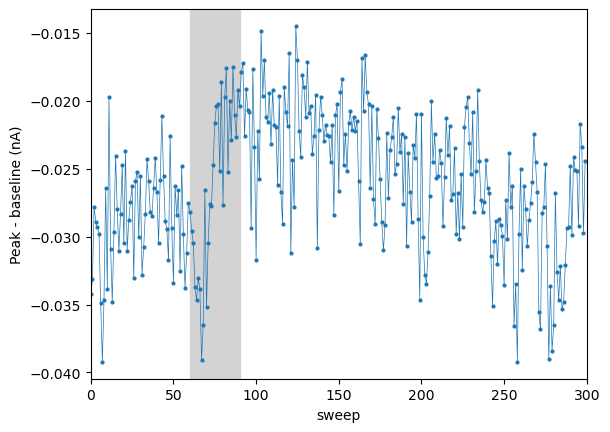

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


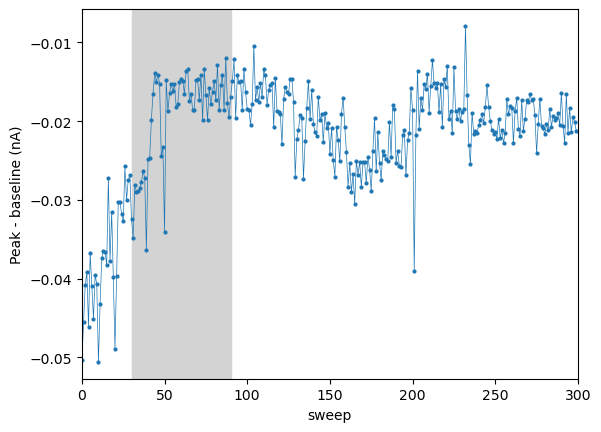

File : 09Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 17  min.


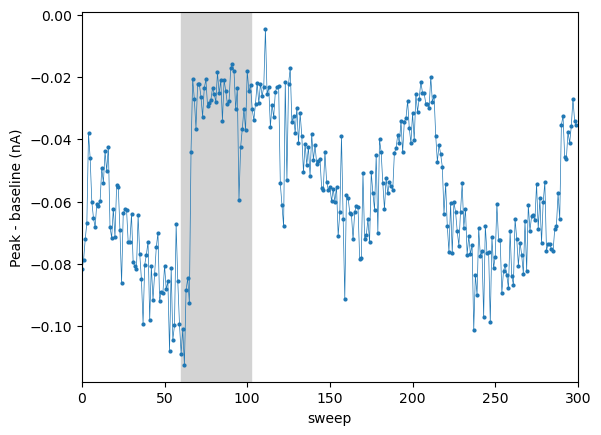

In [21]:
i=0
for datafile in datafiles:
    try:
        #print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        #datafile = loadpxp(file)
        recordings = get_recordings(datafile)

        diffs = []
        for recording in recordings:
            diff = find_diff(recording)
            if diff>-0.17 :
                diffs.append(diff)

        fig, ax = plt.subplots()
        ax.plot(diffs, marker = "o", linewidth = 0.5, markersize=2 )
        ax.set_xlim(0,300)
        #ax.set_ylim(-0.06, -0.01)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("sweep")
        ax.axvspan(info_df["infusion start"][i]*6, info_df["infusion end"][i]*6, color='lightgrey')
        
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

## 50 BATCHES of 6 POINTS EACH

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


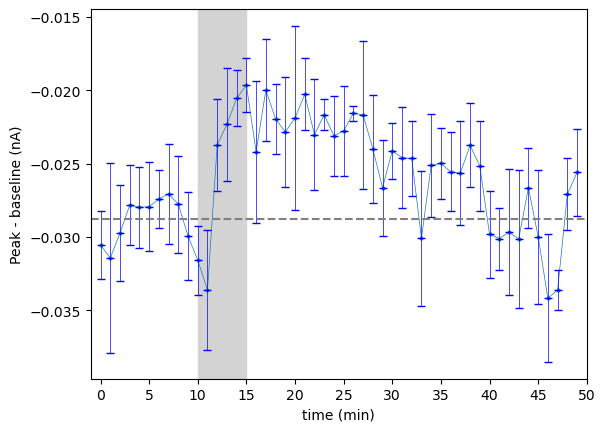

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


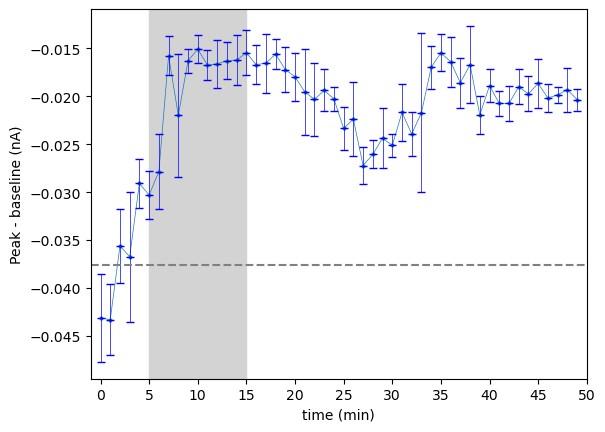

File : 09Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 17  min.


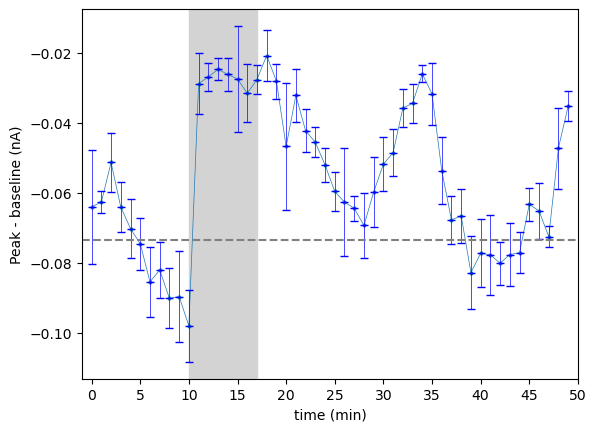

In [19]:
i=0
for datafile in datafiles:
    try:

        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        #datafile = loadpxp(file)
        recordings = get_recordings(datafile)
        diffs = get_diffs(recordings)
        batches_m, batches_std = get_batches(diffs)

        fig, ax = plt.subplots()
        
        ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
        ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

        ax.set_xlim(-1,50)
        #ax.set_ylim(-0.14, 0)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("time (min)")
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        ax.set_xticks(np.arange(0, 51, 5))
        plt.axhline(np.mean(batches_m[0:info_df["infusion start"][i]]), color = "grey", linestyle = "--")
  
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

## NORMALIZATION BY BASELINE

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


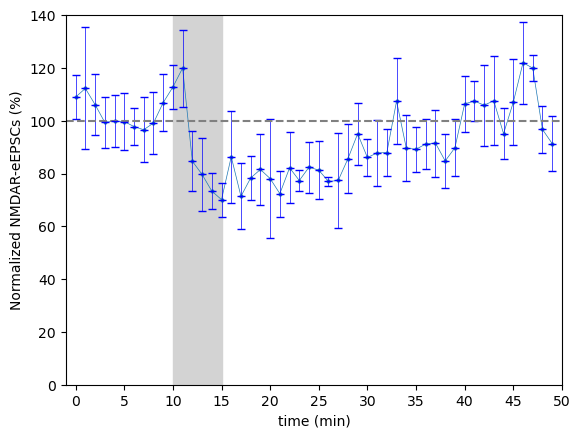

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


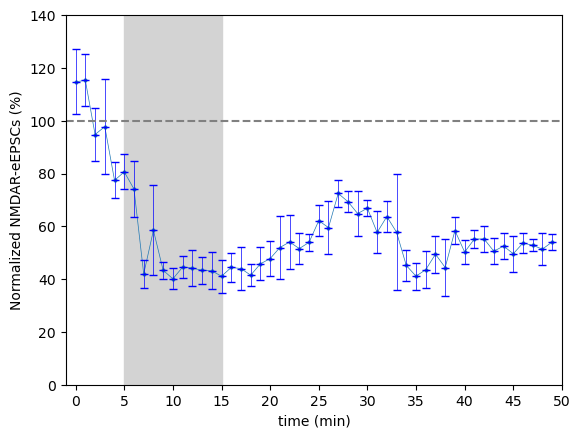

File : 09Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 17  min.
cell was lost at the sweep  53  ( =  8.833333333333334  min)
cell was lost at the sweep  55  ( =  9.166666666666666  min)
cell was lost at the sweep  60  ( =  10.0  min)
cell was lost at the sweep  61  ( =  10.166666666666666  min)
cell was lost at the sweep  62  ( =  10.333333333333334  min)
cell was lost at the sweep  237  ( =  39.5  min)


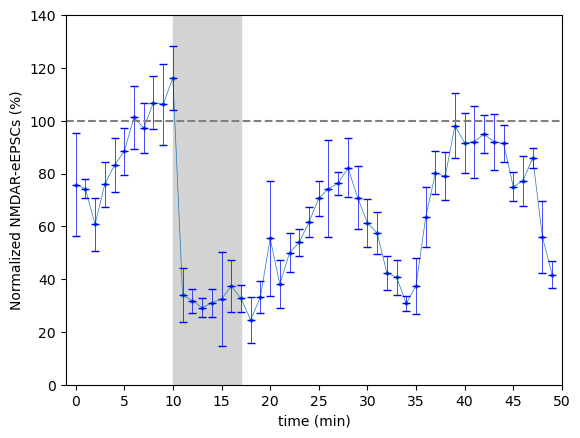

In [23]:
i = 0

for datafile in datafiles:
    try:
        #print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

        
       #info file
        recordings = get_recordings(datafile)
        #diffs = get_diffs2(recordings)
        diffs = get_diffs3(recordings)
        batches_m, batches_std = get_batches(diffs)
        #print(batches_m[0:10])
        #print(batches_m[10:15])
        #print(batches_m[15:50])

        # Calculate baseline mean and standard deviation
        baseline_m = np.mean(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])
        baseline_std = np.std(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])

        # Normalization by baseline
        batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
        batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

        fig, ax = plt.subplots()
        ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax.set_xlim(-1, 50 )
        ax.set_ylim( 0, 140)
        ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax.set_xlabel("time (min)")
        ax.set_xticks(np.arange(0, 51, 5))
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        plt.axhline(100, color="grey", linestyle="--")

        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1


## NORMALIZATION BY BASELINE WITHOUT NOISE

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


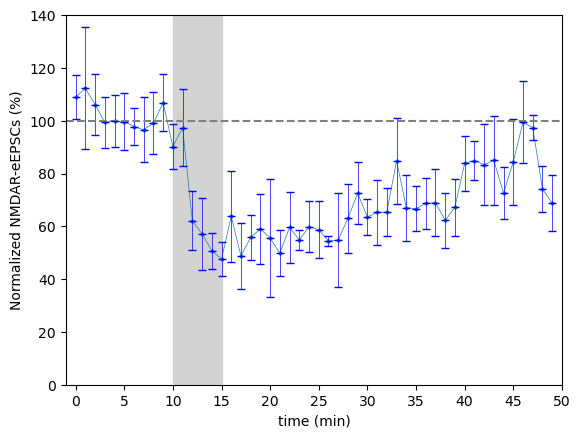

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


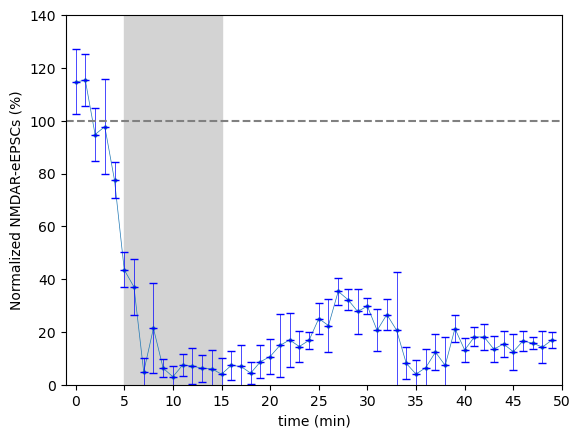

File : 09Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 17  min.
cell was lost at the sweep  53  ( =  8.833333333333334  min)
cell was lost at the sweep  55  ( =  9.166666666666666  min)
cell was lost at the sweep  60  ( =  10.0  min)
cell was lost at the sweep  61  ( =  10.166666666666666  min)
cell was lost at the sweep  62  ( =  10.333333333333334  min)
cell was lost at the sweep  237  ( =  39.5  min)


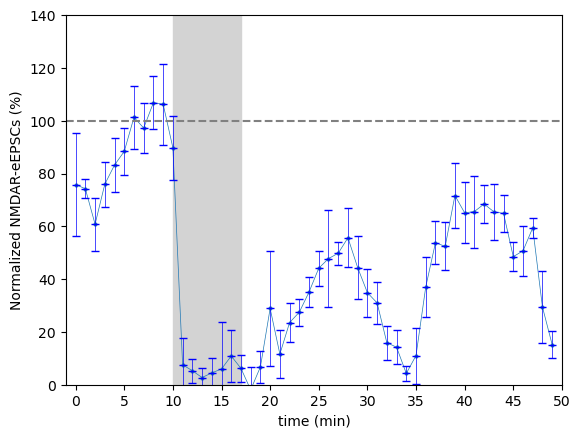

In [24]:
i = 0

for datafile in datafiles:
    try:
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

       #info file
        recordings = get_recordings(datafile)
        #diffs = get_diffs2(recordings)
        diffs = get_diffs3(recordings)
        batches_m, batches_std = get_batches(diffs)
        
        #print("data before standardization :")
        #print(batches_m)

        # Standardization by baseline mean (Baseline at 100%)
        baseline_m = np.mean(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])
        batches_m_norm = (batches_m / baseline_m) * 100  
        batches_std_norm = (batches_std / baseline_m) * 100  
        #print("batches after standardization :")
        #print(batches_m_norm)
        #print(batches_std_norm)

        #remove noise 
        std_baseline = get_std_baseline(info_df, diffs)
        #noise = np.sqrt(std_baseline)
        noise = 2*std_baseline
        noise_norm = (noise/baseline_m) * 100
        #print("noise : ", noise)
        #print("noise norm", noise_norm)
        for j in range(info_df["infusion start"][i],len(batches_m_norm)):
            batches_m_norm[j] = np.max(batches_m_norm[j]-noise_norm, 0)
        #print("batches after standardization after removing noise")
        #print(batches_m_norm )
        
        fig, ax = plt.subplots()
        ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax.set_xlim(-1, 50 )
        ax.set_ylim( 0, 140)
        ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax.set_xlabel("time (min)")
        ax.set_xticks(np.arange(0, 51, 5))
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        plt.axhline(100, color="grey", linestyle="--")

        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1


## + BASELINE EVOLUTION (LEAK) + PEAK MEM CHECK (ACCESS)

In [14]:
i = 0

for datafile in datafiles:
    try:
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

       #info file
        recordings = get_recordings(datafile)
        #diffs = get_diffs2(recordings)
        diffs = get_diffs3(recordings) #noise was removed here
        print(diffs[info_df["infusion start"][i]*6:info_df["infusion end"][i]*6])
        batches_m, batches_std = get_batches(diffs)
        
        #print("data before standardization :")
        #print(batches_m)

        # Standardization by baseline mean (Baseline at 100%)
        baseline_m = np.mean(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])
        batches_m_norm = (batches_m / baseline_m) * 100  
        batches_std_norm = (batches_std / baseline_m) * 100  
        #print("batches after standardization :")
        #print(batches_m_norm)
        #print(batches_std_norm)

        '''
        #remove noise 
        std_baseline = get_std_baseline(info_df, diffs)
        #noise = np.sqrt(std_baseline)
        noise = 2*std_baseline
        noise_norm = (noise/baseline_m) * 100
        #print("noise : ", noise)
        #print("noise norm", noise_norm)
        for j in range(info_df["infusion start"][i],len(batches_m_norm)):
            batches_m_norm[j] = np.maximum(batches_m_norm[j]-noise_norm, 0)
        #print("batches after standardization after removing noise")
        #print(batches_m_norm )
        '''

        baselines = get_baselines(recordings)
        baselines_m, baselines_std = get_batches(baselines)
        #print(baselines_m)

        Ids = get_Ids(recordings)
        Ids_m, Ids_std = get_batches(Ids)
        #print(Ids_m)
        

        #plots
        fig, ax = plt.subplots(3, 1)
        ax[0].plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax[0].errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax[0].set_xlim(-1, 50 )
        ax[0].set_ylim( -10, 140)
        ax[0].set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax[0].set_xlabel("time (min)")
        ax[0].set_xticks(np.arange(0, 51, 5))
        ax[0].axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        ax[0].axhline(100, color="grey", linestyle="--")

        ax[1].plot(baselines_m, marker="o", linewidth=0.5, markersize=2)
        ax[1].errorbar(range(len(baselines_m)), baselines_m, yerr=baselines_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax[1].set_xlim(-1, 50 )
        #ax[1].set_ylim( -0.6, 0.1)
        ax[1].set_ylabel("Baseline (=leak) (nA)")
        ax[1].set_xlabel("time (min)")
        ax[1].set_xticks(np.arange(0, 51, 5))
        ax[1].axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')

        ax[2].plot(Ids_m, marker="o", linewidth=0.5, markersize=2)
        ax[2].errorbar(range(len(Ids_m)), Ids_m, yerr=Ids_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax[2].set_xlim(-1, 50 )
        #ax[2].set_ylim( 0, 140)
        ax[2].set_ylabel("Id (=acces) (nA)")
        ax[2].set_xlabel("time (min)")
        ax[2].set_xticks(np.arange(0, 51, 5))
        ax[2].axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')

        fig.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1


NameError: name 'datafiles' is not defined